<a href="https://colab.research.google.com/github/AllanVikiru/ComputerSimulationsKNN/blob/master/Simulations_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Group Members**
1. Allan Vikiru – 098587 (BICS 4A) [Chairperson]
2. Kelsey Makale – 100052 (BICS 4A)
3. Nicole Muswanya – 101112 (BICS 4A)
4. Stephen Wanyee – 100565 (BICS 4A)
5. Daniel Olamide – 102214 (BICS 4A)




### Library Imports

In [170]:
!pip install seaborn

In [171]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

### Preview Dataset

In [172]:
from google.colab import files
uploads = files.upload()

Saving Health Systems Dataset.csv to Health Systems Dataset (1).csv


In [173]:
data = pd.read_csv('Health Systems Dataset.csv')
data.head()

,Country_Region,Province_State,World_Bank_Name,Health_exp_pct_GDP_2016,Health_exp_public_pct_2016,Health_exp_out_of_pocket_pct_2016,Health_exp_per_capita_USD_2016,per_capita_exp_PPP_2016,External_health_exp_pct_2016,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,Completeness_of_death_reg_2008-16
0,Afghanistan,NaN,Afghanistan,10.2,5.1,77.4,57.2,162.8,17.5,0.3,0.3,0.0,42.3,NaN
1,Albania,NaN,Albania,6.7,41.4,58.0,271.5,759.7,0.7,1.2,3.6,11.6,98.4,53.0
2,Algeria,NaN,Algeria,6.6,67.7,30.9,260.4,998.2,0.0,1.8,2.2,12.1,100.0,NaN
3,Andorra,NaN,Andorra,10.4,49.1,41.7,3834.7,4978.7,NaN,3.3,4.0,83.1,100.0,80.0
4,Angola,NaN,Angola,2.9,44.1,35.2,95.2,185.8,3.6,0.2,1.3,NaN,25.0,NaN


In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Country_Region                        187 non-null    object 
 1   Province_State                        14 non-null     object 
 2   World_Bank_Name                       210 non-null    object 
 3   Health_exp_pct_GDP_2016               186 non-null    float64
 4   Health_exp_public_pct_2016            186 non-null    float64
 5   Health_exp_out_of_pocket_pct_2016     186 non-null    float64
 6   Health_exp_per_capita_USD_2016        186 non-null    float64
 7   per_capita_exp_PPP_2016               186 non-null    float64
 8   External_health_exp_pct_2016          167 non-null    float64
 9   Physicians_per_1000_2009-18           189 non-null    float64
 10  Nurse_midwife_per_1000_2009-18        189 non-null    float64
 11  Specialist_surgical

### Data Cleaning and Preparation
> Firstly, we clean the data, ridding of redundant columns and filling missing values.

*   Drop the `Province_State` column because only 14 columns are filled and it does not influence the classification in any way.
*   Drop `Country_Region` as the `World_Bank_Name` can be used as the unique identifier
*   Replace missing values with either mean or mode



In [175]:
#dropping column
data = data.drop(['Country_Region', 'Province_State'], axis=1)

#replacing Nan with mean
replace_with_mean = ['Health_exp_pct_GDP_2016', 'Health_exp_public_pct_2016', 'Health_exp_out_of_pocket_pct_2016', 'Health_exp_per_capita_USD_2016', 'per_capita_exp_PPP_2016', 
                     'External_health_exp_pct_2016', 'Physicians_per_1000_2009-18', 'Nurse_midwife_per_1000_2009-18', 'Specialist_surgical_per_1000_2008-18']
for feature in replace_with_mean:
  mean_value = data[feature].mean()
  data[feature].fillna(mean_value, inplace=True)

#replace with mode
replace_with_mode = ['Completeness_of_birth_reg_2009-18', 'Completeness_of_death_reg_2008-16']
for feature in replace_with_mode:
  mode_value = data[feature].mode()[0]
  data[feature].fillna(mode_value, inplace=True)

data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   World_Bank_Name                       210 non-null    object 
 1   Health_exp_pct_GDP_2016               210 non-null    float64
 2   Health_exp_public_pct_2016            210 non-null    float64
 3   Health_exp_out_of_pocket_pct_2016     210 non-null    float64
 4   Health_exp_per_capita_USD_2016        210 non-null    float64
 5   per_capita_exp_PPP_2016               210 non-null    float64
 6   External_health_exp_pct_2016          210 non-null    float64
 7   Physicians_per_1000_2009-18           210 non-null    float64
 8   Nurse_midwife_per_1000_2009-18        210 non-null    float64
 9   Specialist_surgical_per_1000_2008-18  210 non-null    float64
 10  Completeness_of_birth_reg_2009-18     210 non-null    float64
 11  Completeness_of_dea

,World_Bank_Name,Health_exp_pct_GDP_2016,Health_exp_public_pct_2016,Health_exp_out_of_pocket_pct_2016,Health_exp_per_capita_USD_2016,per_capita_exp_PPP_2016,External_health_exp_pct_2016,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,Completeness_of_death_reg_2008-16
0,Afghanistan,10.2,5.1,77.4,57.2,162.8,17.500000,0.3,0.3,0.000000,42.3,100.0
1,Albania,6.7,41.4,58.0,271.5,759.7,0.700000,1.2,3.6,11.600000,98.4,53.0
2,Algeria,6.6,67.7,30.9,260.4,998.2,0.000000,1.8,2.2,12.100000,100.0,100.0
3,Andorra,10.4,49.1,41.7,3834.7,4978.7,9.116766,3.3,4.0,83.100000,100.0,80.0
4,Angola,2.9,44.1,35.2,95.2,185.8,3.600000,0.2,1.3,37.937143,25.0,100.0


### Feature Selection


> We carried out further selection to determine the choose the relevant features based on their values.

* For this, we plotted a heatmap, to determine collinearity between features.



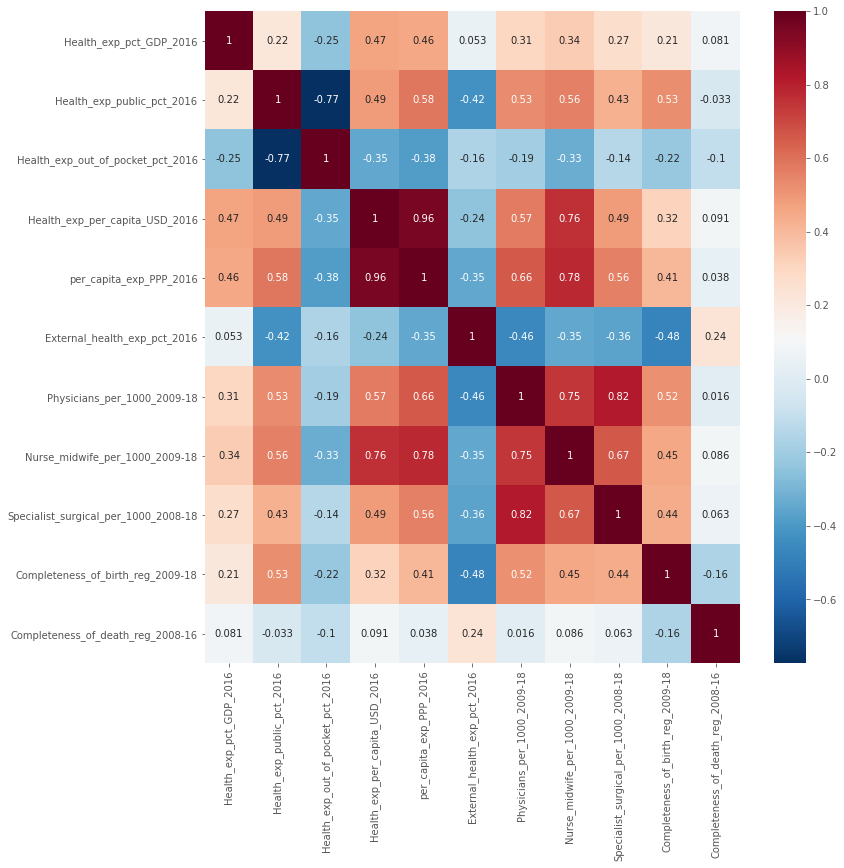

In [176]:
df = data.copy()
matrix = df.corr() # correlation matrix
dimensions = matrix.index
plt.figure(figsize=(12,12))
h_map=sns.heatmap(df[dimensions].corr(),annot=True, cmap="RdBu_r")


* Based on the map, there is a wide variance in collinearity: -0.77 being the least between `Health_exp_public_pct_2016` and `Health_exp_out_of_pocket_pct_2016`; and the highest (0.96) between `Health_exp_per_capita_USD_2016` and `per_capita_exp_PPP_2016`.


* This implies that `Health_exp_public_pct_2016` and `Health_exp_out_of_pocket_pct_2016` have very differing values, which would contribute greatly to model perfomance. 

* On the other hand, `Health_exp_per_capita_USD_2016` and `per_capita_exp_PPP_2016` have very similar values due to the minimal collinearity and thus dropping one feature would not impact much to the model performance. After deliberation, we therefore dropped the `Health_exp_per_capita_USD_2016` feature.

* After dropping, the new set of features would be:






In [177]:
new_features_frame = df.drop(columns=['Health_exp_per_capita_USD_2016'],axis=1)
new_features_frame

,World_Bank_Name,Health_exp_pct_GDP_2016,Health_exp_public_pct_2016,Health_exp_out_of_pocket_pct_2016,per_capita_exp_PPP_2016,External_health_exp_pct_2016,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,Completeness_of_death_reg_2008-16
0,Afghanistan,10.200000,5.100000,77.400000,162.800000,17.500000,0.30000,0.300000,0.000000,42.3,100.0
1,Albania,6.700000,41.400000,58.000000,759.700000,0.700000,1.20000,3.600000,11.600000,98.4,53.0
2,Algeria,6.600000,67.700000,30.900000,998.200000,0.000000,1.80000,2.200000,12.100000,100.0,100.0
3,Andorra,10.400000,49.100000,41.700000,4978.700000,9.116766,3.30000,4.000000,83.100000,100.0,80.0
4,Angola,2.900000,44.100000,35.200000,185.800000,3.600000,0.20000,1.300000,37.937143,25.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...
205,Virgin Islands (U.S.),6.715054,52.915054,32.661828,1412.466667,9.116766,1.72328,4.139153,37.937143,100.0,100.0
206,West Bank and Gaza,6.715054,52.915054,32.661828,1412.466667,9.116766,1.72328,4.139153,37.937143,96.0,100.0
207,"Yemen, Rep.",5.600000,10.200000,81.000000,144.500000,7.800000,0.30000,0.700000,0.800000,30.7,100.0
208,Zambia,4.500000,38.300000,12.100000,175.200000,42.500000,0.10000,0.900000,1.500000,11.3,100.0


### Feature Encoding

> Next, we set out to encode our data for easier classification as high spenders and low spenders.

*  First, we encoded the country names `World_Bank_Name` in a dataframe `categorical_frame`, where it's presence would indicate a 1 and its absence a 0.

In [178]:
nominal = ['World_Bank_Name']
names_frame= df.select_dtypes(include=['object']).copy()
names_frame

,World_Bank_Name
0,Afghanistan
1,Albania
2,Algeria
3,Andorra
4,Angola
...,...
205,Virgin Islands (U.S.)
206,West Bank and Gaza
207,"Yemen, Rep."
208,Zambia


In [179]:
categorical_frame = names_frame.copy()
categorical_frame = pd.concat([pd.get_dummies(categorical_frame[nominal]),categorical_frame],axis=1)
categorical_frame.drop(nominal,axis=1,inplace=True)
categorical_frame

,World_Bank_Name_Afghanistan,World_Bank_Name_Albania,World_Bank_Name_Algeria,World_Bank_Name_Andorra,World_Bank_Name_Angola,World_Bank_Name_Antigua and Barbuda,World_Bank_Name_Argentina,World_Bank_Name_Armenia,World_Bank_Name_Australia,World_Bank_Name_Austria,World_Bank_Name_Azerbaijan,"World_Bank_Name_Bahamas, The",World_Bank_Name_Bahrain,World_Bank_Name_Bangladesh,World_Bank_Name_Barbados,World_Bank_Name_Belarus,World_Bank_Name_Belgium,World_Bank_Name_Belize,World_Bank_Name_Benin,World_Bank_Name_Bhutan,World_Bank_Name_Bolivia,World_Bank_Name_Bosnia and Herzegovina,World_Bank_Name_Botswana,World_Bank_Name_Brazil,World_Bank_Name_Brunei Darussalam,World_Bank_Name_Bulgaria,World_Bank_Name_Burkina Faso,World_Bank_Name_Burundi,World_Bank_Name_Cabo Verde,World_Bank_Name_Cambodia,World_Bank_Name_Cameroon,World_Bank_Name_Canada,World_Bank_Name_Cayman Islands,World_Bank_Name_Central African Republic,World_Bank_Name_Chad,World_Bank_Name_Channel Islands,World_Bank_Name_Chile,World_Bank_Name_China,World_Bank_Name_Colombia,World_Bank_Name_Comoros,...,World_Bank_Name_South Africa,World_Bank_Name_South Sudan,World_Bank_Name_Spain,World_Bank_Name_Sri Lanka,World_Bank_Name_St. Kitts and Nevis,World_Bank_Name_St. Lucia,World_Bank_Name_St. Martin (French part),World_Bank_Name_St. Vincent and the Grenadines,World_Bank_Name_Sudan,World_Bank_Name_Suriname,World_Bank_Name_Sweden,World_Bank_Name_Switzerland,World_Bank_Name_Syrian Arab Republic,World_Bank_Name_Tajikistan,World_Bank_Name_Tanzania,World_Bank_Name_Thailand,World_Bank_Name_Timor-Leste,World_Bank_Name_Togo,World_Bank_Name_Tonga,World_Bank_Name_Trinidad and Tobago,World_Bank_Name_Tunisia,World_Bank_Name_Turkey,World_Bank_Name_Turkmenistan,World_Bank_Name_Turks and Caicos Islands,World_Bank_Name_Tuvalu,World_Bank_Name_Uganda,World_Bank_Name_Ukraine,World_Bank_Name_United Arab Emirates,World_Bank_Name_United Kingdom,World_Bank_Name_United States,World_Bank_Name_Uruguay,World_Bank_Name_Uzbekistan,World_Bank_Name_Vanuatu,"World_Bank_Name_Venezuela, RB",World_Bank_Name_Vietnam,World_Bank_Name_Virgin Islands (U.S.),World_Bank_Name_West Bank and Gaza,"World_Bank_Name_Yemen, Rep.",World_Bank_Name_Zambia,World_Bank_Name_Zimbabwe
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
206,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

* Now, we encode the numerical dataset, ie. the other features which can serve as various labels. 
* The values will be represented as 0 (Low Spender) and 1 (High Spender) which are determined by a specified criteria.
* First, we need to select one label to serve as the target variable. 
* This is determined by plotting the distributions of the different labels and selecting the most symmetrically skewed ie. the mean, mode and median are almost equal:


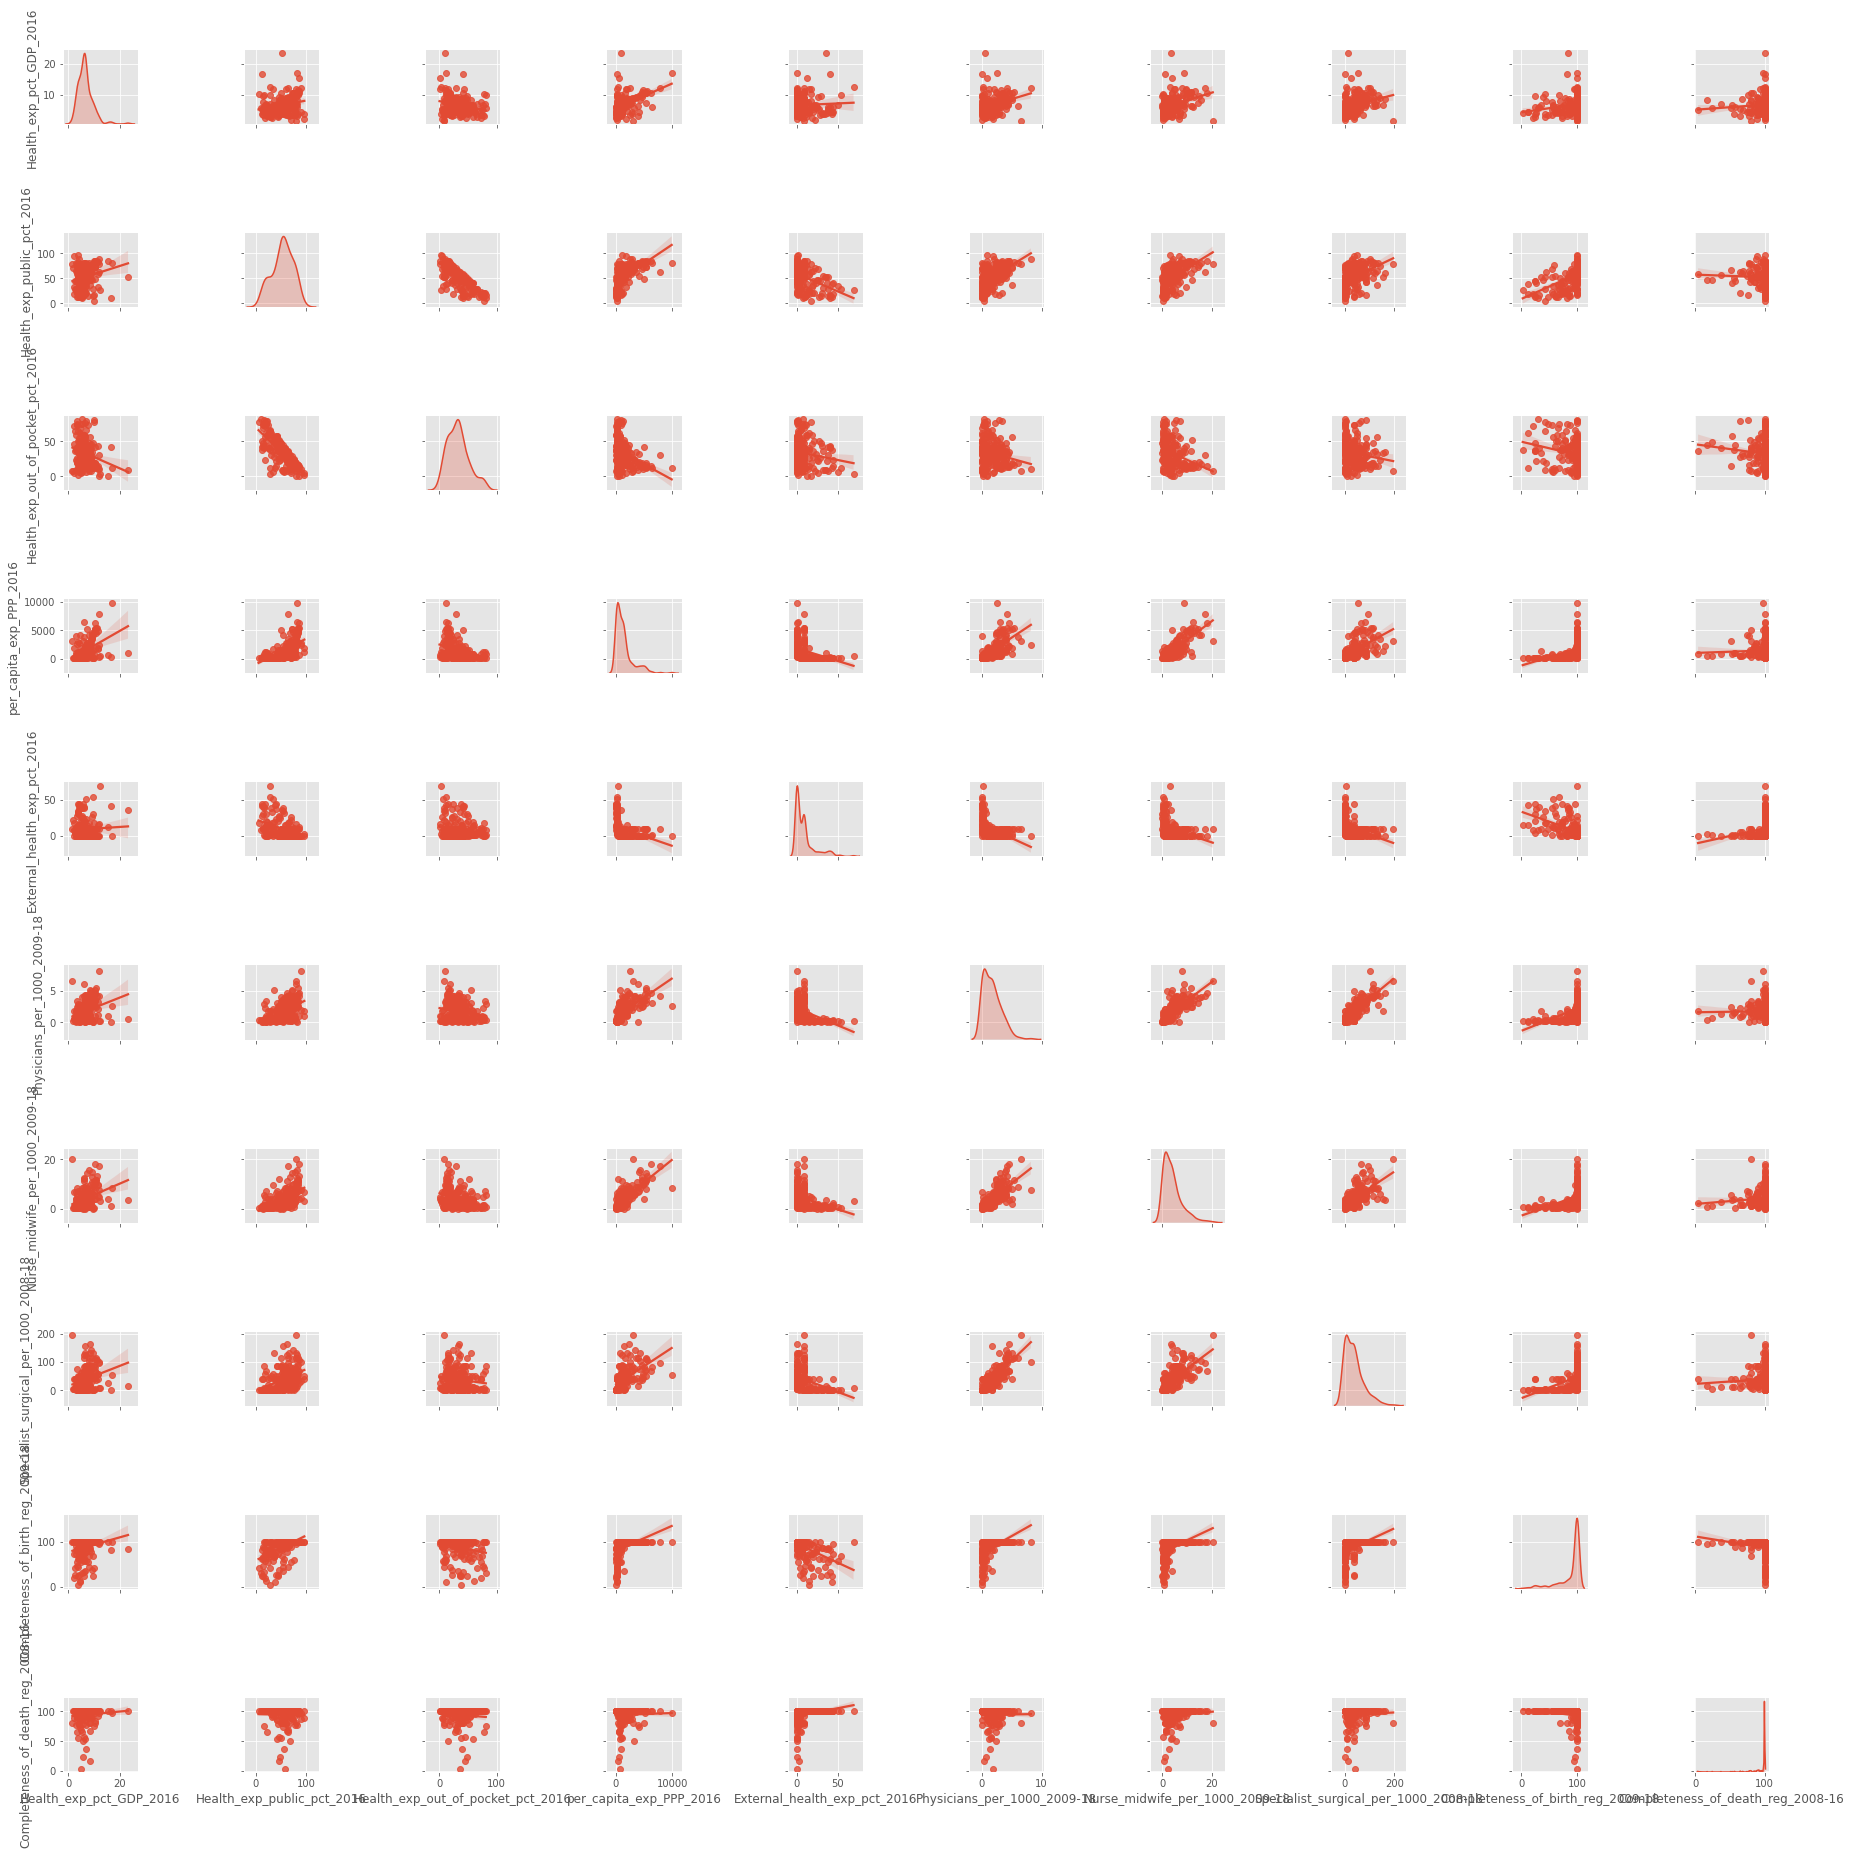

In [180]:
numerical_frame = new_features_frame.drop(columns=nominal,axis=1)
sns.pairplot(numerical_frame,kind='reg',diag_kind='kde')

* Based on the pairplots above, `Health_exp_public_pct_2016` is the most symetrically skewed and thus selected as the target.
* Next, we carry specify the threshold of the target, ie. the criterion for determining the low spenders and high spenders.
* For the threshold, we determined to use the mean value for the label.

count    210.000000
mean      52.915054
std       20.658571
min        5.100000
25%       40.225000
50%       52.915054
75%       68.175000
max       96.000000
Name: Health_exp_public_pct_2016, dtype: float64

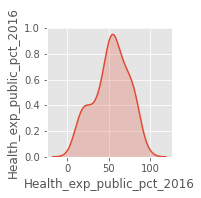

In [181]:
target = numerical_frame.loc[:, 'Health_exp_public_pct_2016']
target_frame = pd.DataFrame(target)

# Health_exp_public_pct_2016 pairplot
sns.pairplot(target_frame,kind='reg',diag_kind='kde')

# description
target.describe()

* We will now use the mean value (`52.9151`)  set the criterion for determining the low and high spenders and encode the target values.


In [182]:
# select target values

criteria = [target.between(0,52), target.between(53,97)]
values = [0, 1]

# create encoded targets dataframe
YLabel = np.select(criteria, values, 0)
YTarget = pd.DataFrame(YLabel)
YTarget.rename(columns = {0:'Target'}, inplace = True) 
YTarget

,Target
0,0
1,0
2,1
3,0
4,0
...,...
205,0
206,0
207,0
208,0




*   Now, we concantenate the features and their target variables:



In [183]:
encoded_frame= pd.concat([data_copy,numerical_frame,YTarget],axis=1)
encoded_frame

,World_Bank_Name_Afghanistan,World_Bank_Name_Albania,World_Bank_Name_Algeria,World_Bank_Name_Andorra,World_Bank_Name_Angola,World_Bank_Name_Antigua and Barbuda,World_Bank_Name_Argentina,World_Bank_Name_Armenia,World_Bank_Name_Australia,World_Bank_Name_Austria,World_Bank_Name_Azerbaijan,"World_Bank_Name_Bahamas, The",World_Bank_Name_Bahrain,World_Bank_Name_Bangladesh,World_Bank_Name_Barbados,World_Bank_Name_Belarus,World_Bank_Name_Belgium,World_Bank_Name_Belize,World_Bank_Name_Benin,World_Bank_Name_Bhutan,World_Bank_Name_Bolivia,World_Bank_Name_Bosnia and Herzegovina,World_Bank_Name_Botswana,World_Bank_Name_Brazil,World_Bank_Name_Brunei Darussalam,World_Bank_Name_Bulgaria,World_Bank_Name_Burkina Faso,World_Bank_Name_Burundi,World_Bank_Name_Cabo Verde,World_Bank_Name_Cambodia,World_Bank_Name_Cameroon,World_Bank_Name_Canada,World_Bank_Name_Cayman Islands,World_Bank_Name_Central African Republic,World_Bank_Name_Chad,World_Bank_Name_Channel Islands,World_Bank_Name_Chile,World_Bank_Name_China,World_Bank_Name_Colombia,World_Bank_Name_Comoros,...,World_Bank_Name_Switzerland,World_Bank_Name_Syrian Arab Republic,World_Bank_Name_Tajikistan,World_Bank_Name_Tanzania,World_Bank_Name_Thailand,World_Bank_Name_Timor-Leste,World_Bank_Name_Togo,World_Bank_Name_Tonga,World_Bank_Name_Trinidad and Tobago,World_Bank_Name_Tunisia,World_Bank_Name_Turkey,World_Bank_Name_Turkmenistan,World_Bank_Name_Turks and Caicos Islands,World_Bank_Name_Tuvalu,World_Bank_Name_Uganda,World_Bank_Name_Ukraine,World_Bank_Name_United Arab Emirates,World_Bank_Name_United Kingdom,World_Bank_Name_United States,World_Bank_Name_Uruguay,World_Bank_Name_Uzbekistan,World_Bank_Name_Vanuatu,"World_Bank_Name_Venezuela, RB",World_Bank_Name_Vietnam,World_Bank_Name_Virgin Islands (U.S.),World_Bank_Name_West Bank and Gaza,"World_Bank_Name_Yemen, Rep.",World_Bank_Name_Zambia,World_Bank_Name_Zimbabwe,Health_exp_pct_GDP_2016,Health_exp_public_pct_2016,Health_exp_out_of_pocket_pct_2016,per_capita_exp_PPP_2016,External_health_exp_pct_2016,Physicians_per_1000_2009-18,Nurse_midwife_per_1000_2009-18,Specialist_surgical_per_1000_2008-18,Completeness_of_birth_reg_2009-18,Completeness_of_death_reg_2008-16,Target
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.200000,5.100000,77.400000,162.800000,17.500000,0.30000,0.300000,0.000000,42.3,100.0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.700000,41.400000,58.000000,759.700000,0.700000,1.20000,3.600000,11.600000,98.4,53.0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6.600000,67.700000,30.900000,998.200000,0.000000,1.80000,2.200000,12.100000,100.0,100.0,1
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.400000,49.100000,41.700000,4978.700000,9.116766,3.30000,4.000000,83.100000,100.0,80.0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.900000,44.100000,35.200000,185.800000,3.600000,0.20000,1.300000,37.937143,25.0,100.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6.715054,52.915054,32.661828,1412.466667,9.116766,1.72328,4.139153,37.937143,100.0,100.0,0
206,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,

### Feature Extraction

> Now, we create a new set of features on a lower dimensionality space. This is done by selecting the encoded features and standardising data an to fit a Normal distribution using *PowerTransformer*

In [184]:
data_features = list(encoded_frame.columns)
data_features
X = encoded_frame.loc[:,data_features[0]:data_features[-2]].values
Y = encoded_frame.loc[:,[data_features[-1]]].values

std_X = PowerTransformer().fit_transform(X)
std_X

array([[14.45683229, -0.06917145, -0.06917145, ..., -1.71331924,
        -2.02451153,  0.54406798],
       [-0.06917145, 14.45683229, -0.06917145, ..., -0.5049101 ,
         0.52955956, -2.41747901],
       [-0.06917145, -0.06917145, 14.45683229, ..., -0.47890448,
         0.70839789,  0.54406798],
       ...,
       [-0.06917145, -0.06917145, -0.06917145, ..., -1.50360351,
        -2.08755153,  0.54406798],
       [-0.06917145, -0.06917145, -0.06917145, ..., -1.37056328,
        -2.11135147,  0.54406798],
       [-0.06917145, -0.06917145, -0.06917145, ..., -1.35385133,
        -2.05498457,  0.54406798]])

### Model Implementation and Training

> Before fitting the model, we split the data into train and test data at a ratio of 7:3

In [185]:
X_train, X_test, y_train, y_test = train_test_split(std_X,Y,test_size=0.3,random_state=101)

* Next, we implement Principal Component Analysis (PCA) to form new latent features of the training data values of X to 2 components.
* This greatly enhances model accuracy.

In [186]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

* Now, we train the model using the training set and use a random value of k to test for the model's performance

In [187]:
#Set random value of K neighbours to 3
knn = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets
knn.fit(X_train, y_train.ravel())

# Test 
pred_i = knn.predict(X_test)

#Checking performance on the training set
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))


#Checking performance on the test set
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.88
Accuracy of K-NN classifier on test set: 0.83




*   Next, we determine the optimal value of k by plotting it against the error rate.



In [188]:
error_rate = []
for i in range (1,10):
  knn = KNeighborsClassifier(n_neighbors=i)
  knn.fit(X_train, y_train.ravel())
  pred_i = knn.predict(X_test)
  error_rate.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Error Rate')

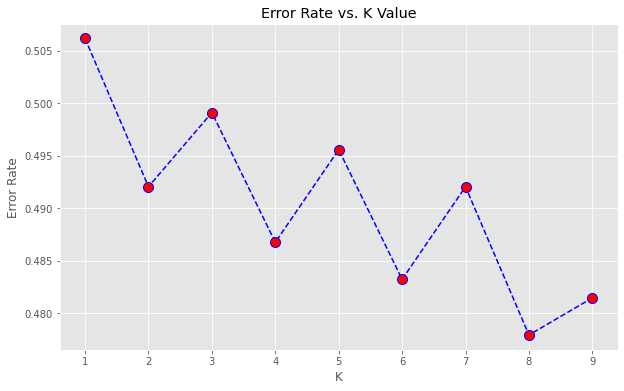

In [189]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')



*  Using the optimal value of k as 8, we can now determine the actual model accuracy as follows:



In [190]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, y_train.ravel())
pred_i = knn.predict(X_test)

print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.85
Accuracy of K-NN classifier on test set: 0.79


### Data Visualisation

> The final step is to visualise the data using the `matplotlib` function

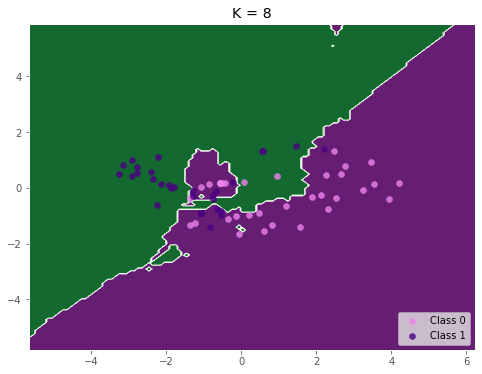

In [191]:
%matplotlib inline
matplotlib.style.use('ggplot') 

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
padding = 0.1
resolution = 0.1
k = 8

colors = {0: 'violet', 1: 'indigo', 2: 'palegreen'}
x_min, x_max = X_train[:, 0].min(), X_train[:, 0].max()
y_min, y_max = X_train[:, 1].min(), X_train[:, 1].max()
x_range = x_max - x_min
y_range = y_max - y_min
x_min -= x_range * padding
y_min -= y_range * padding
x_max += x_range * padding
y_max += y_range * padding

# Get decision boundaries from model
xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                     np.arange(y_min, y_max, resolution))

Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the contour map
plt.contourf(xx, yy, Z, cmap=plt.cm.PRGn)
plt.axis('tight')

# Plot your testing points as well
for label in np.unique(y_test):
    indices = np.where(y_test == label)
    plt.scatter(X_test[indices, 0], X_test[indices, 1], c=colors[label], alpha=0.8, 
                label='Class {}'.format(label))

plt.legend(loc='lower right')
plt.title('K = {}'.format(k))
plt.show()

> Based on the graph above, classes 0 and 1 represent the low and high spenders respectively. The countries are highlighted as the coloured dots specified by these classes

> The green region represents the high spender class, while the purple region represents the low spender class. The white line separating the regions represents the class boundary.